데이터와 모델을 불러오는 중...
설정 파일(model_metrics.json)을 찾지 못해 기본값(0.5)을 사용합니다.
분석 준비 완료.

1. 모델 종합 리포트 (Classification Report)
              precision    recall  f1-score   support

  잔존(Active)       0.97      0.96      0.97      1536
 이탈(Churned)       0.88      0.91      0.89       464

    accuracy                           0.95      2000
   macro avg       0.93      0.94      0.93      2000
weighted avg       0.95      0.95      0.95      2000


2. 특성 중요도 분석
중요도를 계산하는 중입니다...


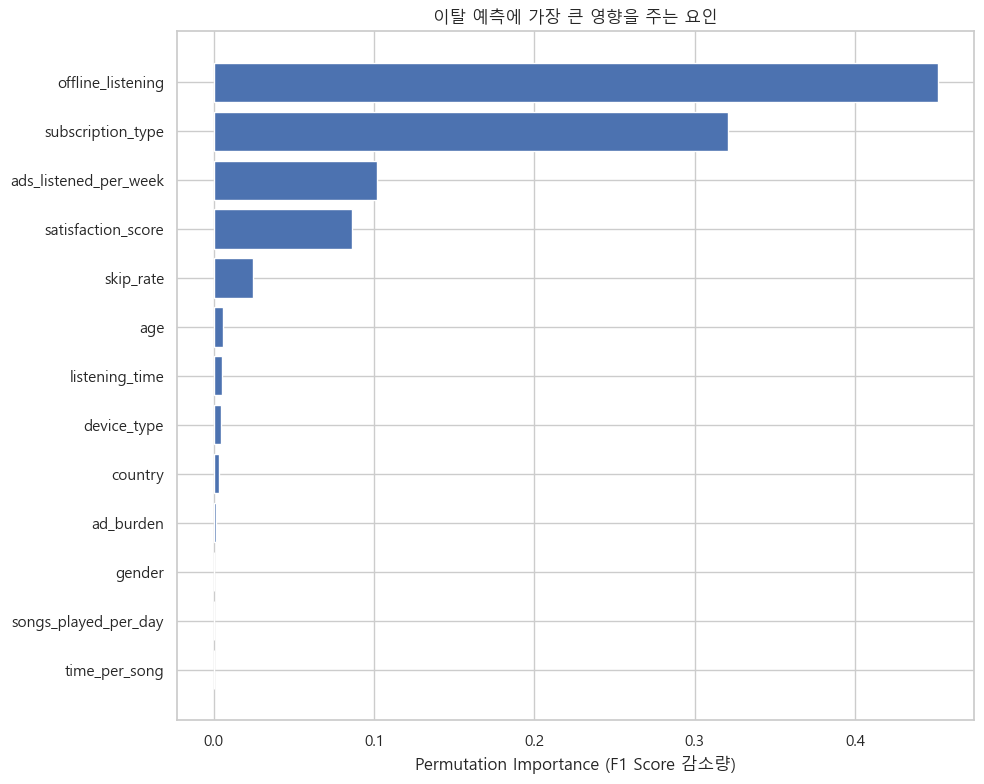


3. 혼동 행렬 분석


<Figure size 600x600 with 0 Axes>

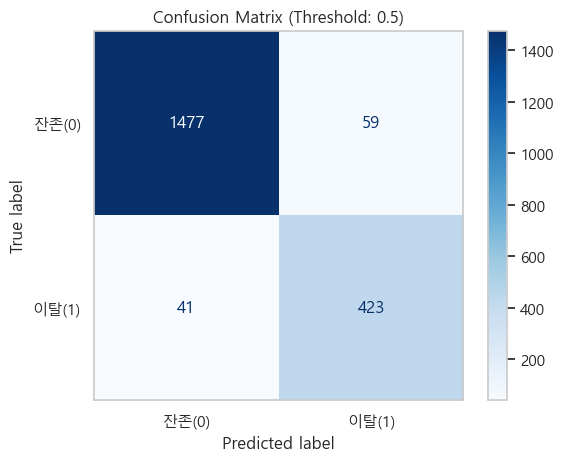

상세 해석:
- 실제 잔존 / 예측 잔존 (TN): 1477명 (잘 맞춤)
- 실제 이탈 / 예측 이탈 (TP): 423명 (잘 맞춤)
- 실제 잔존 / 예측 이탈 (FP): 59명 (오진 - 마케팅 비용 낭비)
- 실제 이탈 / 예측 잔존 (FN): 41명 (놓침 - 위험)
총 테스트 인원: 2000명 (검증: 2000명)

4. ROC Curve & AUC


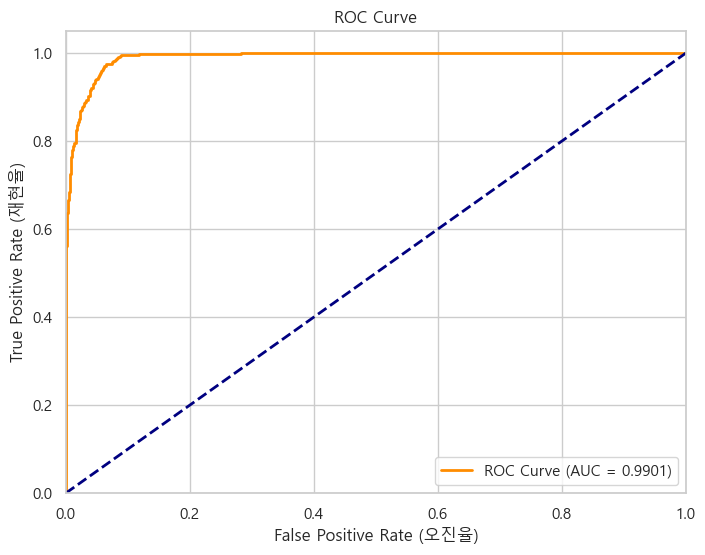

AUC 점수: 0.9901
해석: AUC가 1에 가까울수록 모델의 변별력이 뛰어납니다.


In [4]:
import pandas as pd
import numpy as np
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report
from sklearn.inspection import permutation_importance

# LightGBM 관련 경고 메시지 무시 설정
warnings.filterwarnings('ignore', message='X does not have valid feature names')

# 시각화 스타일 설정
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'Malgun Gothic' # Windows 기준 (Mac은 'AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 데이터 및 모델 로드
print("데이터와 모델을 불러오는 중...")

# 데이터 로드
df = pd.read_csv('data/spotify_churn_dataset.csv')

# Feature Engineering (학습 때와 동일하게 적용)
df['ad_burden'] = df['ads_listened_per_week'] / (df['listening_time'] + 1)
df['satisfaction_score'] = df['songs_played_per_day'] * (1 - df['skip_rate'])
df['time_per_song'] = df['listening_time'] / (df['songs_played_per_day'] + 1)

if 'user_id' in df.columns:
    df = df.drop(columns=['user_id'])

X = df.drop(columns=['is_churned'])
y = df['is_churned']

# 테스트 데이터 분리 (전체의 20%인 2000명 추출)
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 저장된 모델 파이프라인 로드
model_pipeline = joblib.load('models/spotify_churn_model.pkl')

# model_metrics.json에서 최적의 임계값(Threshold) 불러오기
try:
    with open('model_metrics.json', 'r') as f:
        metrics = json.load(f)
    threshold = metrics.get('threshold', 0.5) # 없으면 기본값 0.5
    print(f"적용된 임계값(Threshold): {threshold}")
except FileNotFoundError:
    threshold = 0.5
    print("설정 파일(model_metrics.json)을 찾지 못해 기본값(0.5)을 사용합니다.")

print("분석 준비 완료.\n")


# 예측 수행 (Threshold 적용)
# 모델이 예측한 이탈 확률값 가져오기
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

# 불러온 임계값을 기준으로 0(잔존)과 1(이탈) 결정
y_pred_custom = (y_pred_proba >= threshold).astype(int)


# 1. 모델 종합 리포트
print("1. 모델 종합 리포트 (Classification Report)")
print(classification_report(y_test, y_pred_custom, target_names=['잔존(Active)', '이탈(Churned)']))


# 2. 특성 중요도 분석 (Permutation Importance)
print("\n2. 특성 중요도 분석")
print("중요도를 계산하는 중입니다...")

result = permutation_importance(
    model_pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring='f1'
)

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 8))
plt.barh(X_test.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance (F1 Score 감소량)")
plt.title("이탈 예측에 가장 큰 영향을 주는 요인")
plt.tight_layout()
plt.show()


# 3. 혼동 행렬 분석 (Confusion Matrix)
print("\n3. 혼동 행렬 분석")
cm = confusion_matrix(y_test, y_pred_custom)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['잔존(0)', '이탈(1)'])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix (Threshold: {threshold})")
plt.grid(False)
plt.show()

# 결과 상세 해석
tn, fp, fn, tp = cm.ravel()
print("상세 해석:")
print(f"- 실제 잔존 / 예측 잔존 (TN): {tn}명 (잘 맞춤)")
print(f"- 실제 이탈 / 예측 이탈 (TP): {tp}명 (잘 맞춤)")
print(f"- 실제 잔존 / 예측 이탈 (FP): {fp}명 (오진 - 마케팅 비용 낭비)")
print(f"- 실제 이탈 / 예측 잔존 (FN): {fn}명 (놓침 - 위험)")
print(f"총 테스트 인원: {len(y_test)}명 (검증: {tn+tp+fp+fn}명)")


# 4. ROC Curve & AUC
print("\n4. ROC Curve & AUC")
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (오진율)')
plt.ylabel('True Positive Rate (재현율)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC 점수: {roc_auc:.4f}")
print("해석: AUC가 1에 가까울수록 모델의 변별력이 뛰어납니다.")